In [1]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

from aind_vr_foraging_analysis.utils.parsing import data_access, parse
import aind_vr_foraging_analysis.utils.plotting as plotting
import aind_vr_foraging_analysis.utils as processing


# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import pytz

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='yellow'
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'Z:\scratch\vr-foraging\sessions'
foraging_figures = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\Roxana-Dayan collaboration\figures'

from scipy.optimize import curve_fit

color_dict_label = {'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 
    'PatchZ': '#d95f02', 'PatchZB': '#d95f02', 
    'PatchB': '#d95f02','PatchA': '#7570b3', 
    'PatchC': '#1b9e77',
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'S': color1,
    'D': color2,
    'N': color3,
    "odor_90": color1,
    "odor_60": color2,
    "odor_0": color3,
    'A': color1,
    'B': color2,
    'C': color3,
    }

label_dict = {**{
"InterSite": '#808080',
"InterPatch": '#b3b3b3'}, 
            **color_dict_label}

from matplotlib.lines import Line2D


In [2]:
# Function to assign codes
def get_condition_code(text):
    if 'delayed' in text:
        return 'D'
    elif 'single' in text:
        return 'S'
    elif 'no_reward' in text or 'noreward' in text:
        return 'N'
    elif "double" in text:
        return 'Do'
    else:
        return text

In [3]:
from aind_vr_foraging_analysis.utils.parsing import data_access

date_string = "2025-09-17" # YYYY-MM-DD
mouse = '789918' # mouse ID

# This section will look at all the session paths that fulfill the condition
session_paths = data_access.find_sessions_relative_to_date(
    mouse=mouse,
    date_string=date_string,
    when='on'
)

# Iterate over the session paths and load the data
for session_path in session_paths:
    print(f"Loading {session_path.name}...")
    try:
        all_epochs, stream_data, data = data_access.load_session(
            session_path
        )
        odor_sites = all_epochs.loc[all_epochs['label'] == 'OdorSite']
    except Exception as e:
        print(f"Error loading {session_path.name}: {e}")
        
all_epochs['patch_label'] = all_epochs['patch_label'].apply(get_condition_code)

Loading 789918_2025-09-17T193015Z...
Reward functions from software events


In [4]:
mouse_list = ['789910', '788641', '789919', '789913', '789918', '789908']

In [5]:
def replenishment_curves(data, save = None):
    test = data['software_events'].streams.GlobalPatchState.data.copy()
    test.reset_index(inplace=True)
    folded = pd.json_normalize(data['software_events'].streams.GlobalPatchState.data['data'])
    df_final = pd.concat([test, folded], axis=1)
    df_final.set_index('Seconds', inplace=True)
    df_final.index = df_final.index - df_final.index[0]

    test = data['software_events'].streams.ActivePatch.data.copy()
    test.reset_index(inplace=True)
    folded = pd.json_normalize(data['software_events'].streams.ActivePatch.data['data'])
    epochs = pd.concat([test, folded], axis=1)
    epochs.reset_index(inplace=True)
    epochs.set_index('Seconds', inplace=True)
    epochs.index = epochs.index - epochs.index[0]

    color_dict_label = {'A': '#d95f02',
                        'B': '#1b9e77',
                        'C': '#7570b3',
                        0: '#d95f02',
                        1: '#1b9e77',
                        2: '#7570b3',}

    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(data=df_final, x=df_final.index, y='Probability', hue='PatchId', palette=color_dict_label, ax=ax, legend=False, marker='o')


    # Step 1: find contiguous blocks of the same label
    intervals = []
    current_label = epochs["label"].iloc[0]
    start = epochs.index[0]

    for t, lbl in epochs["label"].items():
        if lbl != current_label:
            # end of a block
            intervals.append((start, t, current_label))
            current_label = lbl
            start = t
            
    # add the last one
    intervals.append((start, df_final.index[-1], current_label))

    for start, stop, lbl in intervals:
        ax.axvspan(start, stop, color=color_dict_label[lbl], alpha=0.5, linewidth=0, )

    ax.set_ylim(0, 1.1)
    ax.set_xlabel("Time")
    # Custom legend
    legend_elements = [
        Line2D([0], [0], color=color_dict_label['A'], lw=4, label='Patch A'),
        Line2D([0], [0], color=color_dict_label['B'], lw=4, label='Patch B'),
        Line2D([0], [0], color=color_dict_label['C'], lw=4, label='Patch C'),
    ]
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handles=legend_elements, title='Patch ID')
    sns.despine()  
    if save == None:
        plt.show()
    else:
        save.savefig(fig, bbox_inches='tight')
        plt.close()


In [6]:
date_string = "2025-09-18"
df = pd.DataFrame()
for mouse in mouse_list:
    session_paths = data_access.find_sessions_relative_to_date(
        mouse=mouse,
        date_string=date_string,
        when='on_or_after'
    )
    session_n = 0
    with PdfPages(f'{foraging_figures}/Replenishment_Curves_{mouse}.pdf') as pdf:
        for session_path in session_paths:
            print(mouse, session_path)
            try:
                all_epochs, stream_data, data = data_access.load_session(
                    session_path
                )
                session_n += 1
                all_epochs['stage'] = data['config'].streams.tasklogic_input.data['stage_name']
                all_epochs['mouse'] = mouse
                all_epochs['session'] = session_path.name
                all_epochs['session_n'] = session_n
            except:
                print(f"Error loading {session_path.name}")
                continue
            df = pd.concat([df, all_epochs])    
            replenishment_curves(data, save = pdf)

789910 Z:\scratch\vr-foraging\data\789910\789910_2025-09-18T215701Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\789910_2025-09-19T204527Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\789910_2025-09-23T215522Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\789910_2025-09-24T220310Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\789910_2025-09-25T221219Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\789910_2025-09-26T204352Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\789910_2025-09-29T205928Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\789910_2025-09-30T211251Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\789910_2025-10-01T203924Z
Reward functions from software events
789910 Z:\scratch\vr-foraging\data\789910\7899

In [7]:
df = df.loc[(df.mouse != '789919')|(df.session_n != 6)]

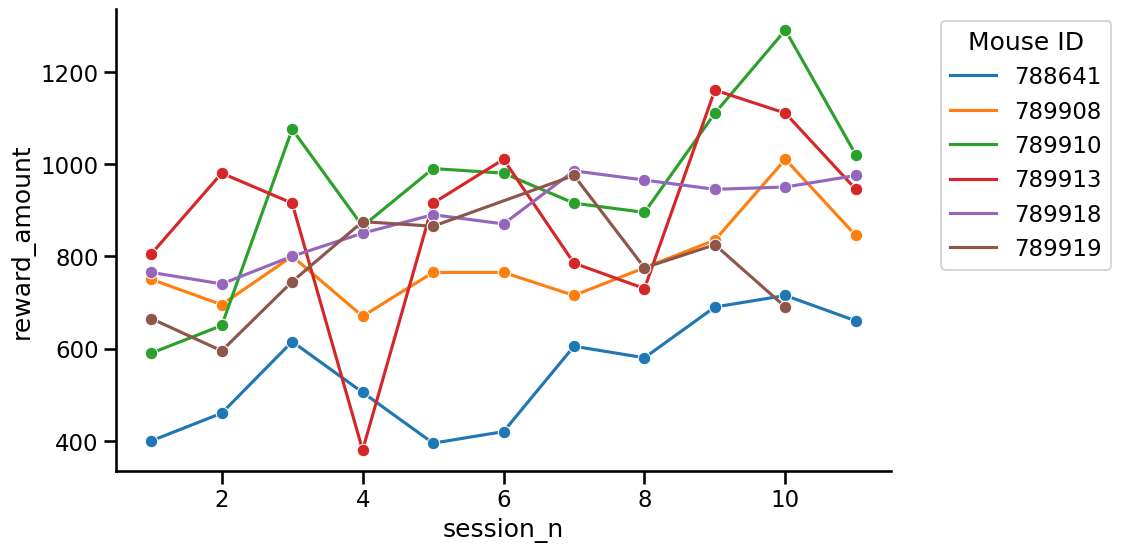

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
plot = df.loc[df.is_reward == 1].groupby(['mouse', 'session_n']).reward_amount.sum().reset_index()
sns.lineplot(data=plot, errorbar='sd', x='session_n', y='reward_amount', hue='mouse', marker = 'o')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Mouse ID')

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

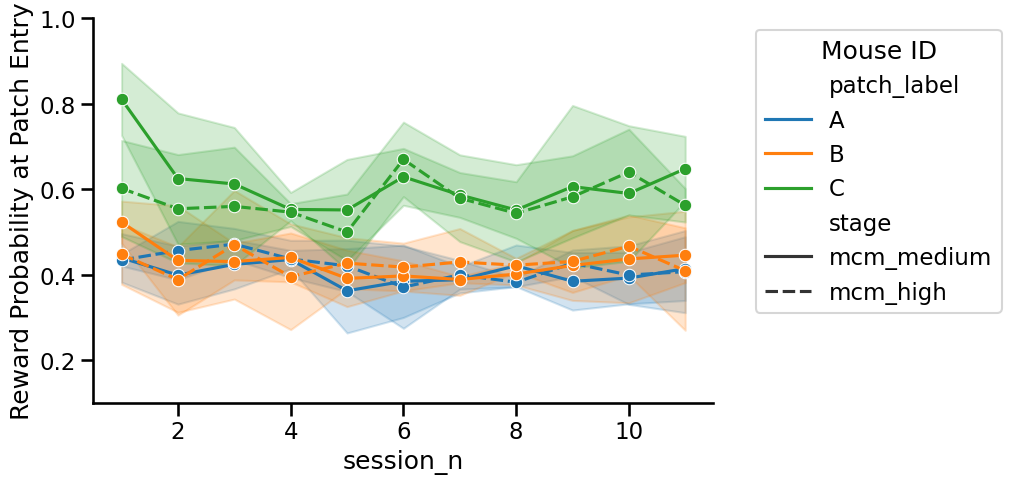

In [9]:
plot = df.loc[df.site_number == 0].groupby(['mouse', 'session_n', 'stage','patch_label']).reward_probability.mean().reset_index()
fig, ax = plt.subplots(1,1, figsize=(8, 5))

sns.lineplot(data=plot, errorbar='sd', x='session_n', y='reward_probability', hue='patch_label', marker = 'o', style='stage', ax=ax)
sns.despine()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Mouse ID')
ax.set_ylim(0.1, 1)
# plt.show()
ax.set_ylabel('Reward Probability at Patch Entry')
plt.tight_layout
    

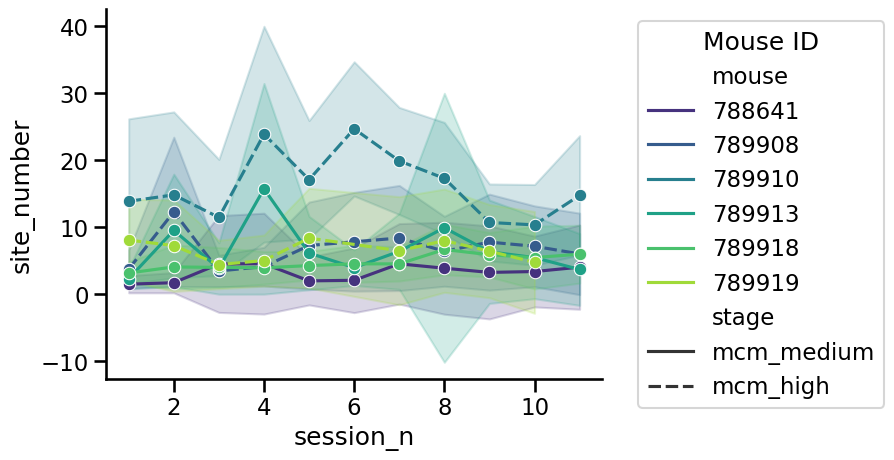

In [10]:
plot = df.groupby(['mouse', 'session_n', 'stage','patch_label', 'patch_number']).site_number.count().reset_index()

sns.lineplot(data=plot, x='session_n', y='site_number', hue='mouse',style ='stage',ci='sd', palette='viridis', marker='o')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Mouse ID')
sns.despine()

<Axes: xlabel='session_n', ylabel='site_number'>

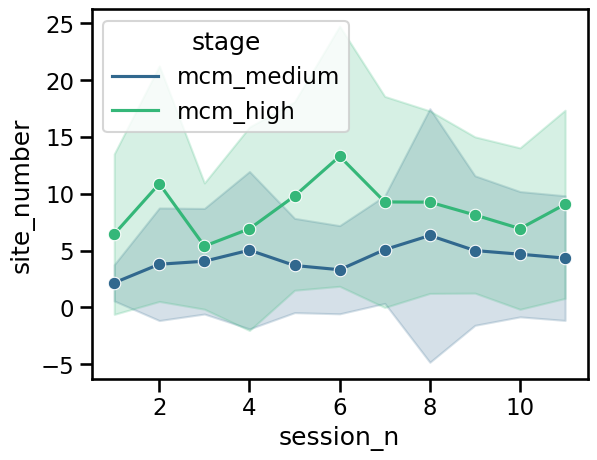

In [11]:
plot = df.groupby(['mouse', 'session_n', 'stage','patch_label', 'patch_number']).site_number.count().reset_index()

sns.lineplot(data=plot, x='session_n', y='site_number', hue='stage', ci='sd', palette='viridis', marker='o')